# CNN - Exercise
In the tutorial Standing on the Shoulders of Giants you investigated a computer vision problem of your choice by applying transfer learning to a series of input images of your choice. For this exercise, you should re-use the weights for the convolutional layers and train the other layers of the model using your own input images and evaluate the results
Hand in your Jupyter notebook which also functions as a research report. You describe the context of the problem at hand, the methods, the results and your conclusion.

## Preparation
In this section useful libraries are imported which are used in most data science projects.

In [1]:
import os
import sys

# sets the path to the home directory of this repository so other modules can be imported. 
project_path = os.getcwd()
root_path = os.path.split(os.path.split(os.getcwd())[0])[0]
assert root_path.endswith("Fontys-ADS"), "The root path does not end with Fontys-ADS: " + root_path 
sys.path.insert(0, root_path)

import numpy as np
import tensorflow as tf
print(tf.__version__)
# set the seed for reproducible results.
np.random.seed(56)
tf.random.set_seed(56)

# optionally, set TensorFlow to use the GPU with all available memory.
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

2.3.0


# Data collection
For this assignment, I have used the cats_vs_dogs image dataset neatly provided by the TensorFlow datasets API.

In [2]:
import pandas as pd
import tensorflow_datasets as tfds
ds, info = tfds.load('cats_vs_dogs', split='train', with_info=True)
assert isinstance(ds, tf.data.Dataset)

# Preparing the data
explain how the data is prepared

In [3]:
from datasets.base_image_dataset import ImageDatasetBase

# the dataset class
class CatsVsDogsDataset(ImageDatasetBase):
    def __init__(self, ds, batch_size, img_height, img_width, data_size, train_percentage, validation_percentage, test_percentage):
        super().__init__(batch_size, img_height, img_width)

        # sets the data.
        self.data = ds.map(self.process_frame, num_parallel_calls=tf.data.experimental.AUTOTUNE)

        # shuffles the dataset
        self.shuffle(256)

        # splits the data into train, validation, and test datasets.
        self.split_data_to_train_val_test(self.data, train_percentage, validation_percentage, test_percentage, data_size / batch_size)

    def process_frame(self, ds):
        # convert image to 0..1
        img = tf.image.convert_image_dtype(ds['image'], tf.float32)

        # resize the image to the desired size.
        return tf.image.resize(img, [self.img_height, self.img_width]), ds['label']

In [4]:
data_size = 23262
img_height = 224
img_width = 224
img_channels = 3
classes = 2

batch_size = 64
train_percentage = 0.6
validation_percentage = 0.2
test_percentage = 0.2
dataset = CatsVsDogsDataset(ds, batch_size, img_height, img_width, data_size, train_percentage, validation_percentage, test_percentage)

train: 218 validation: 72 test: 72


# Exploratory Data Analysis
Explore the data to gain insights on possible features

64


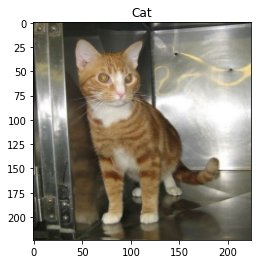

In [5]:
import matplotlib.pyplot as plt
class_names = ['Cat', 'Dog']
for img, label in dataset.train_ds.take(1):
    print(len(img.numpy()))
    fig, ax = plt.subplots(1, 1)
    ax.imshow(img[0])
    ax.set_title(class_names[label[0].numpy()])

# Modelling
Apply ML/DL models

In [6]:
from models.base_model import ModelBase
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.activations import elu

class SuperCatDogClassifier(ModelBase):
    def __init__(self, img_height, img_width, img_channels, classes, gpu_initialized=False, training=False, limit=5000):
        super().__init__(gpu_initialized, training, limit)
        # the name for the model.
        self.name = 'SuperCatDogClassifier'

        # set img dimensions.
        self.img_height = img_height
        self.img_width = img_width
        self.img_channels = img_channels

        # set the classes.
        self.classes = classes

    def predict(self, X):
        prediction = self.model.predict(X, verbose=1)
        return prediction

    def fit(self, training, callbacks, epochs, validation, validation_steps, steps_per_epoch):
        return self.model.fit(
            training,
            callbacks=callbacks,
            epochs=epochs,
            validation_data=validation,
            validation_steps=validation_steps,
            steps_per_epoch=steps_per_epoch, verbose=1)

    def compile(self, optimizer='adam', loss='mse', metrics=['mse'], loss_weights=[1.0], show_summary=False):
        self.inputs = Input((self.img_height, self.img_width, self.img_channels))

        c1 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(self.inputs)
        p1 = MaxPooling2D((2, 2))(c1)

        c9 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
        p2 = MaxPooling2D((2, 2))(c9)

        c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
        p3 = MaxPooling2D((2, 2))(c2)

        f = Flatten()(p3)
        d1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(f)

        self.outputs = Dense(1, activation='sigmoid')(d1)

        self.model = Model(inputs=self.inputs, outputs=self.outputs, name=self.name)

        self.model.compile(optimizer=optimizer, loss=loss, metrics=metrics, loss_weights=loss_weights)

        if show_summary:
            self.model.summary()

In [7]:
model = SuperCatDogClassifier(img_height, img_width, img_channels, classes, training=True, gpu_initialized=True)

In [8]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
import datetime

epochs = 100
model.compile(optimizer=Adam(lr = 1e-4), loss='binary_crossentropy', metrics=['accuracy'], show_summary=True)

# current time
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# create logging
log_dir = os.path.join(project_path, f'logs\{model.name}\{current_time}')

# create all callbacks
callbacks = [
  EarlyStopping(patience=10, monitor='val_loss'),
  TensorBoard(log_dir=log_dir, profile_batch=0)
]

Model: &quot;SuperCatDogClassifier&quot;
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None,

In [9]:
%load_ext tensorboard

In [10]:
# fit the model using the training data
results1 = model.fit(
  training=dataset.train_ds,
  callbacks=callbacks,
  epochs=epochs,
  validation=dataset.val_ds,
  validation_steps=dataset.val_size,
  steps_per_epoch=dataset.train_size)
  
# save the weights of the model
weights_path = os.path.join(project_path, f'models\{model.name}_trained_model_weights')
model.save_weights(weights_path)

Epoch 1/100
218/218 [==============================] - 33s 153ms/step - loss: 0.6393 - accuracy: 0.6262 - val_loss: 0.5740 - val_accuracy: 0.7064
Epoch 2/100
218/218 [==============================] - 12s 54ms/step - loss: 0.5501 - accuracy: 0.7183 - val_loss: 0.5222 - val_accuracy: 0.7422
Epoch 3/100
218/218 [==============================] - 11s 49ms/step - loss: 0.5018 - accuracy: 0.7577 - val_loss: 0.4931 - val_accuracy: 0.7598
Epoch 4/100
218/218 [==============================] - 11s 50ms/step - loss: 0.4662 - accuracy: 0.7795 - val_loss: 0.4763 - val_accuracy: 0.7652
Epoch 5/100
218/218 [==============================] - 11s 49ms/step - loss: 0.4353 - accuracy: 0.7992 - val_loss: 0.4664 - val_accuracy: 0.7734
Epoch 6/100
218/218 [==============================] - 11s 49ms/step - loss: 0.4103 - accuracy: 0.8154 - val_loss: 0.4597 - val_accuracy: 0.7812
Epoch 7/100
218/218 [==============================] - 11s 48ms/step - loss: 0.3876 - accuracy: 0.8293 - val_loss: 0.4547 - val_a

# Evaluation
Evaluation of the model performance

In [11]:
# re initialize the model.
model.training = False
model.compile(optimizer=Adam(lr = 1e-4), loss='binary_crossentropy', metrics=['accuracy'], show_summary=False) 
model.load_weights(weights_path)

print('\n# Evaluate on test data')
result = model.evaluate(dataset.actual_test_ds)
print('test loss, test acc:', result)
res = dict(zip(model.get_metric_names(), result))
print(res)


# Evaluate on test data
62/62 [==============================] - 4s 61ms/step - loss: 0.6775 - accuracy: 0.7384
test loss, test acc: [0.6774950623512268, 0.7384072542190552]
{&#39;loss&#39;: 0.6774950623512268, &#39;accuracy&#39;: 0.7384072542190552}


In [12]:
image_batch, label_batch = next(iter(dataset.actual_test_ds))
y_pred = model.predict((image_batch, label_batch))

2/2 [==============================] - 0s 5ms/step


Text(0.5, 0.98, &#39;Accuracy: 0.75% on first batch of 64&#39;)

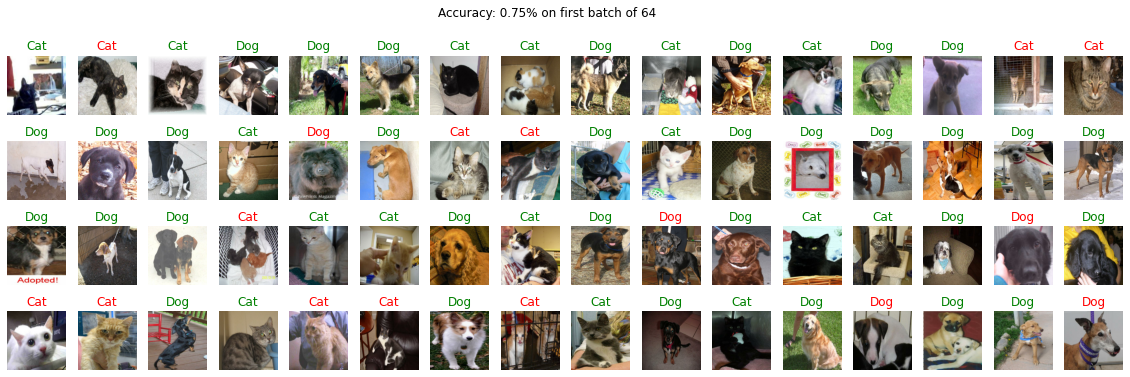

In [13]:
predictions = [round(yhat[0]) for yhat in y_pred]
test_accuracy = sum(predictions == label_batch.numpy()) / len(predictions)
fig = plt.figure(figsize=(20, 6))
for i in range(batch_size):
  ax = plt.subplot(4, 16, i + 1)
  plt.imshow(image_batch[i])
  label = label_batch[i]
  pred = predictions[i]
  color = 'r'
  if label == pred:
    color = 'g'
  fontdict = { 'color': color }
  plt.title(class_names[label], fontdict = fontdict)
  plt.axis("off")
fig.suptitle(f'Accuracy: {test_accuracy:.2f}% on first batch of {batch_size}')

# Results
The results of my cat vs dog classifcation model was not the best, but 73% on a fairly simple architecture is quite good.

# Standing on the shoulder of giants
In this part of the notebook I will build a model using a pre trained base model as the feature extractor.

In [14]:
class SuperCatDogClassifierV2(ModelBase):
    def __init__(self, img_height, img_width, img_channels, classes, gpu_initialized=False, training=False, limit=5000):
        super().__init__(gpu_initialized, training, limit)
        # the name for the model.
        self.name = 'SuperCatDogClassifierV2'

        # set img dimensions.
        self.img_height = img_height
        self.img_width = img_width
        self.img_channels = img_channels

        # set the classes.
        self.classes = classes

    def predict(self, X):
        prediction = self.model.predict(X, verbose=1)
        return prediction

    def fit(self, training, callbacks, epochs, validation, validation_steps, steps_per_epoch):
        return self.model.fit(
            training,
            callbacks=callbacks,
            epochs=epochs,
            validation_data=validation,
            validation_steps=validation_steps,
            steps_per_epoch=steps_per_epoch, verbose=1)

    def compile(self, optimizer='adam', loss='mse', metrics=['mse'], loss_weights=[1.0], show_summary=False):
        self.inputs = Input((self.img_height, self.img_width, self.img_channels))

        x = tf.keras.layers.experimental.preprocessing.Rescaling(2, offset=-1)(self.inputs)
        base_model = tf.keras.applications.MobileNetV2(input_shape=(self.img_height, self.img_width, self.img_channels), include_top=False, weights='imagenet')
        base_model.trainable = False
        x = base_model(x)
        x = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
        x = MaxPooling2D((2, 2))(x)

        x = Flatten()(x)
        x = Dense(128, activation='relu', kernel_initializer='he_uniform')(x)

        self.outputs = Dense(1, activation='sigmoid')(x)

        self.model = Model(inputs=self.inputs, outputs=self.outputs, name=self.name)

        self.model.compile(optimizer=optimizer, loss=loss, metrics=metrics, loss_weights=loss_weights)

        if show_summary:
            self.model.summary()

In [15]:
model = SuperCatDogClassifierV2(img_height, img_width, img_channels, classes, training=True, gpu_initialized=True)

In [16]:
model.compile(optimizer=Adam(lr = 1e-4), loss='binary_crossentropy', metrics=['accuracy'], show_summary=True)

# current time
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# create logging
log_dir = os.path.join(project_path, f'logs\{model.name}\{current_time}')

# create all callbacks
callbacks = [
  EarlyStopping(patience=10, monitor='val_loss'),
  TensorBoard(log_dir=log_dir, profile_batch=0)
]

Model: &quot;SuperCatDogClassifierV2&quot;
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
rescaling (Rescaling)        (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 7, 7, 32)          368672    
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 3, 3, 32)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 288)               0         
_________________________________________________________________
dense_4 (Dense)              (Non

In [17]:
# fit the model using the training data
results2 = model.fit(
  training=dataset.train_ds,
  callbacks=callbacks,
  epochs=epochs,
  validation=dataset.val_ds,
  validation_steps=dataset.val_size,
  steps_per_epoch=dataset.train_size)
  
# save the weights of the model
weights_path = os.path.join(project_path, f'models\{model.name}_trained_model_weights')
model.save_weights(weights_path)

Epoch 1/100
218/218 [==============================] - 15s 67ms/step - loss: 0.0654 - accuracy: 0.9757 - val_loss: 0.0314 - val_accuracy: 0.9881
Epoch 2/100
218/218 [==============================] - 15s 71ms/step - loss: 0.0150 - accuracy: 0.9956 - val_loss: 0.0307 - val_accuracy: 0.9896
Epoch 3/100
218/218 [==============================] - 16s 75ms/step - loss: 0.0058 - accuracy: 0.9990 - val_loss: 0.0297 - val_accuracy: 0.9894
Epoch 4/100
218/218 [==============================] - 17s 76ms/step - loss: 0.0021 - accuracy: 0.9998 - val_loss: 0.0302 - val_accuracy: 0.9896
Epoch 5/100
218/218 [==============================] - 16s 74ms/step - loss: 9.6561e-04 - accuracy: 1.0000 - val_loss: 0.0319 - val_accuracy: 0.9907
Epoch 6/100
218/218 [==============================] - 14s 65ms/step - loss: 3.8996e-04 - accuracy: 1.0000 - val_loss: 0.0330 - val_accuracy: 0.9907
Epoch 7/100
218/218 [==============================] - 15s 68ms/step - loss: 2.3281e-04 - accuracy: 1.0000 - val_loss: 0.0

In [18]:
# re initialize the model.
model.training = False
model.compile(optimizer=Adam(lr = 1e-4), loss='binary_crossentropy', metrics=['accuracy'], show_summary=False) 
model.load_weights(weights_path)

print('\n# Evaluate on test data')
result = model.evaluate(dataset.actual_test_ds)
print('test loss, test acc:', result)
res = dict(zip(model.get_metric_names(), result))
print(res)


# Evaluate on test data
62/62 [==============================] - 6s 96ms/step - loss: 0.0452 - accuracy: 0.9892
test loss, test acc: [0.04516126587986946, 0.9891632795333862]
{&#39;loss&#39;: 0.04516126587986946, &#39;accuracy&#39;: 0.9891632795333862}


In [19]:
y_pred = model.predict((image_batch, label_batch))

1/2 [==============&gt;...............] - ETA: 0sWARNING:tensorflow:Callbacks method `on_predict_batch_end` is slow compared to the batch time (batch time: 0.0070s vs `on_predict_batch_end` time: 0.0210s). Check your callbacks.
2/2 [==============================] - 0s 15ms/step


Text(0.5, 0.98, &#39;Accuracy: 1.00% on first batch of 64&#39;)

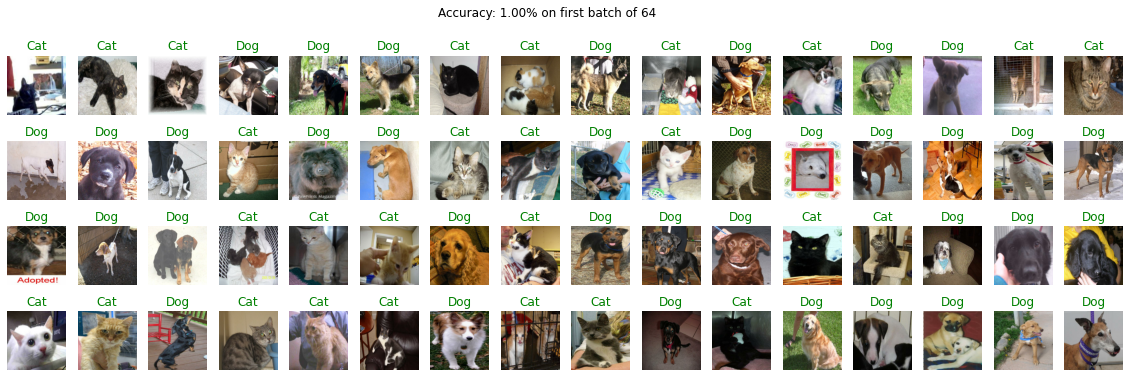

In [20]:
predictions = [round(yhat[0]) for yhat in y_pred]
test_accuracy = sum(predictions == label_batch.numpy()) / len(predictions)
fig = plt.figure(figsize=(20, 6))
for i in range(batch_size):
  ax = plt.subplot(4, 16, i + 1)
  plt.imshow(image_batch[i])
  label = label_batch[i]
  pred = predictions[i]
  color = 'r'
  if label == pred:
    color = 'g'
  fontdict = { 'color': color }
  plt.title(class_names[label], fontdict = fontdict)
  plt.axis("off")
fig.suptitle(f'Accuracy: {test_accuracy:.2f}% on first batch of {batch_size}')

# Results
The results of the model using a MobileNetV2 as base model are impressive. It achieved 98% accuracy on the test set. I do think that it is able to achieve this accuracy because of the weights that are used. ImageNet contains animal classes, so the base model probably has been trained on cat and dogs as well.

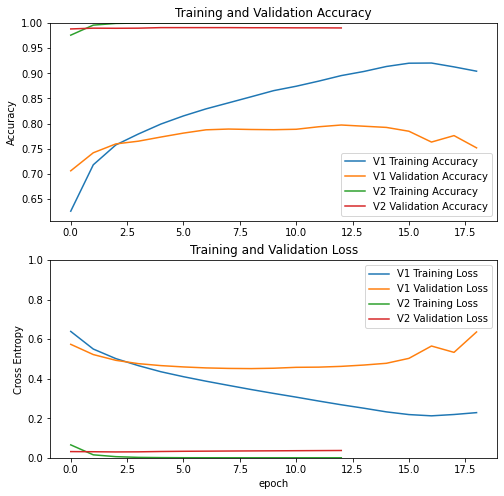

In [21]:
acc1 = results1.history['accuracy']
val_acc1 = results1.history['val_accuracy']

loss1 = results1.history['loss']
val_loss1 = results1.history['val_loss']

acc2 = results2.history['accuracy']
val_acc2 = results2.history['val_accuracy']

loss2 = results2.history['loss']
val_loss2 = results2.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc1, label='V1 Training Accuracy')
plt.plot(val_acc1, label='V1 Validation Accuracy')
plt.plot(acc2, label='V2 Training Accuracy')
plt.plot(val_acc2, label='V2 Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss1, label='V1 Training Loss')
plt.plot(val_loss1, label='V1 Validation Loss')
plt.plot(loss2, label='V2 Training Loss')
plt.plot(val_loss2, label='V2 Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()